<a href="https://colab.research.google.com/github/AnshSharma16/PicassoVision/blob/main/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import tensorflow.keras.applications.vgg19 as vgg19

In [ ]:
def load_and_process_img(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (400, 400))  # Resize for VGG19
    img = img[tf.newaxis, :]  # Add batch dimension
    return img

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        tensor = tensor[0]  # Remove batch dimension
    return PIL.Image.fromarray(tensor)

In [ ]:
# Load content and style images
content_path = tf.keras.utils.get_file("vishnu.jpg", "https://www.gangeswave.com/wp-content/uploads/2021/05/brass_vishnu_statue.jpg")
style_path = tf.keras.utils.get_file("style.jpg", "https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg")


570772/570772 ━━━━━━━━━━━━━━━━━━━━ 1s 2us/step
195196/195196 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
content_image = load_and_process_img(content_path)
style_image = load_and_process_img(style_path)

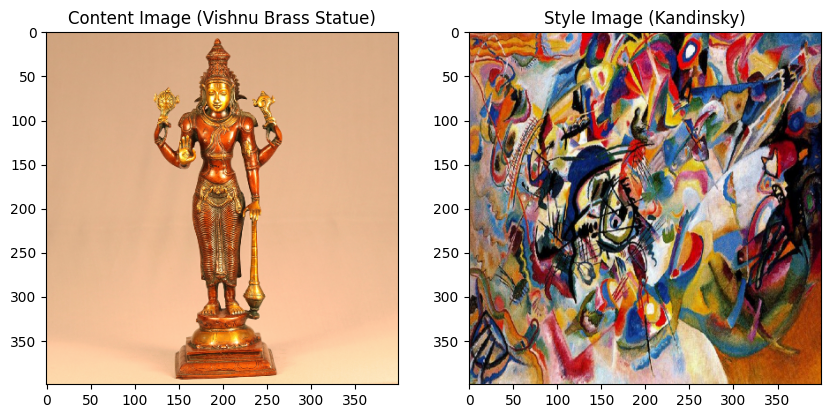

In [ ]:
# Display the images
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(tensor_to_image(content_image))
plt.title("Content Image (Vishnu Brass Statue)")
plt.subplot(1, 2, 2)
plt.imshow(tensor_to_image(style_image))
plt.title("Style Image (Kandinsky)")
plt.show()

In [ ]:
# Load VGG19 model
vgg = vgg19.VGG19(include_top=False, weights="imagenet")
vgg.trainable = False  # Freeze model weights

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Extract feature layers for style and content
content_layers = ["block4_conv2"]  # Mid-layer captures content well
style_layers = [
    "block1_conv1", "block2_conv1", "block3_conv1",
    "block4_conv1", "block5_conv1"
]  # Multiple layers capture texture & patterns

In [ ]:
# Function to create a model that outputs content & style features
def get_vgg_model():
    outputs = [vgg.get_layer(name).output for name in (style_layers + content_layers)]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
# Function to compute content loss (difference between content features)
def content_loss(base_content, target_content):
    return tf.reduce_mean(tf.square(base_content - target_content))

In [ ]:
# Function to compute style loss (Gram matrix difference)
def gram_matrix(feature_maps):
    channels = int(feature_maps.shape[-1])
    features = tf.reshape(feature_maps, [-1, channels])
    gram = tf.matmul(tf.transpose(features), features)
    return gram / tf.cast(tf.shape(features)[0], tf.float32)

In [ ]:
# Function to compute style loss
def style_loss(base_style, target_style):
    base_gram = gram_matrix(base_style)
    target_gram = gram_matrix(target_style)
    return tf.reduce_mean(tf.square(base_gram - target_gram))

In [ ]:
# Extract features from the images
extractor = get_vgg_model()
content_features = extractor(content_image)[len(style_layers):]
style_features = extractor(style_image)[:len(style_layers)]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 400, 400, 3))
  warnings.warn(msg)


In [ ]:
# Set optimization variables
generated_image = tf.Variable(content_image, dtype=tf.float32)
optimizer = tf.keras.optimizers.Adam(learning_rate=5.0)

In [ ]:
# Function to compute total loss (content + style)
def compute_loss():
    generated_features = extractor(generated_image)
    gen_style_features = generated_features[:len(style_layers)]
    gen_content_features = generated_features[len(style_layers):]

    # Compute content loss
    c_loss = content_loss(gen_content_features[0], content_features[0])

    # Compute style loss
    s_loss = sum([style_loss(gs, ts) for gs, ts in zip(gen_style_features, style_features)])
    s_loss /= len(style_layers)  # Average across layers

    # Total loss (higher weight for style)
    total_loss = c_loss * 1e4 + s_loss * 1e-2
    return total_loss

In [ ]:
# Training function
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss = compute_loss()
    grad = tape.gradient(loss, generated_image)
    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image, 0.0, 1.0))  # Keep pixel values valid


In [ ]:
# Training loop
epochs = 500
for i in range(epochs):
    train_step()
    if i % 50 == 0:  # Display progress every 50 steps
        print(f"Step {i} completed")

Step 0 completed
Step 50 completed
Step 100 completed
Step 150 completed
Step 200 completed
Step 250 completed
Step 300 completed
Step 350 completed
Step 400 completed
Step 450 completed


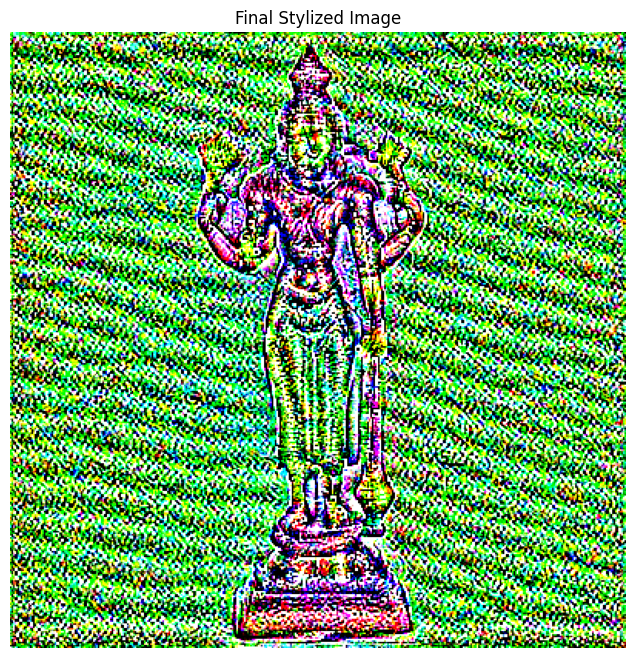

In [ ]:
# Display final stylized image
stylized_img = tensor_to_image(generated_image)
plt.figure(figsize=(8, 8))
plt.imshow(stylized_img)
plt.title("Final Stylized Image")
plt.axis("off")
plt.show()